<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/news_wikification/CNET%20-%20News%20Wikification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Updated to GDS 2.0 version
* Link to original blog post: https://medium.com/neo4j/making-sense-of-news-the-knowledge-graph-way-d33810ce5005

In [ ]:
!pip install neo4j pandas seaborn

In [ ]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot
import pandas as pd
from neo4j import GraphDatabase

driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'letmein'))

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

A wealth of information is being produced every day on the internet. Understanding the news and other content generating websites is becoming increasingly crucial to successfully running a business. It can help you spot opportunities, generate new leads, or provide indicators about the economy. In this blog post, I want to show you how you can create a news monitoring data pipeline that combines Natural language processing and knowledge graphs technologies.

The data pipeline will consist of three parts. In the first part, we will scrape articles from an internet provider of news. Next, we will run the articles through an NLP pipeline and store results in the form of a knowledge graph. In the last part of the data pipeline, we will enrich our knowledge with information from the WikiData API. To demonstrate the benefits of using a knowledge graph to store the information from the data pipeline, we will perform simple network analysis and try to find insights.

We will be using Neo4j to store our knowledge graph. If you want to follow along with this blog post, you need to download Neo4j and install both the APOC and Graph Data Science libraries.Our graph model consists of articles and their tags. Each article has many sections of text. Once we run the section text through the NLP pipeline, we will extract and store mentioned entities back to our graph.We will start by defining unique constraints for our graph.
Unique constraints are used to ensure data integrity as well as to optimize cypher query performance.

In [ ]:
run_query("CREATE CONSTRAINT IF NOT EXISTS ON (a:Article) ASSERT a.url IS UNIQUE;")
run_query("CREATE CONSTRAINT IF NOT EXISTS ON (e:Entity) ASSERT e.wikiDataItemId is UNIQUE;")
run_query("CREATE CONSTRAINT IF NOT EXISTS ON (t:Tag) ASSERT t.name is UNIQUE;")

""


## Internet news scraping
We will scrape the CNET news portal. I have chosen the CNET portal because it has the most consistent HTML structure, making it easier to demonstrate the data pipeline concept without focusing on the scraping element. We will use <code>apoc.load.html</code> procedure for the HTML scraping. It uses jsoup under the hood. Find more information in the documentation.
First, we will iterate over popular topics and store the link of the last dozen of articles for each topic in Neo4j.

In [ ]:
run_query("""
CALL apoc.load.html("https://www.cnet.com/news/", 
  {topics:"div.tag-listing > ul > li > a"}) YIELD value
UNWIND value.topics as topic  
WITH "https://www.cnet.com" + topic.attributes.href as link
CALL apoc.load.html(link, {article:"div.row.asset > div > a"}) YIELD value as articles
UNWIND articles.article as article
WITH distinct "https://www.cnet.com" + article.attributes.href as article_link
MERGE (a:Article{url:article_link});
""")

""


Now that we have the links to the articles, we can go ahead and scrape their content as well as their tags and publishing date. We will store the results according to the graph schema we defined in the previous section.

In [ ]:
run_query("""
MATCH (a:Article)
CALL apoc.load.html(a.url,
{date:"time", title:"h1.speakableText", text:"div.article-main-body > p", tags: "div.tagList > a"}) YIELD value
SET a.datetime = datetime(value.date[0].attributes.datetime)
FOREACH (_ IN CASE WHEN value.title[0].text IS NOT NULL THEN [true] ELSE [] END | 
           CREATE (a)-[:HAS_TITLE]->(:Section{text:value.title[0].text})
)
FOREACH (t in value.tags | 
MERGE (tag:Tag{name:t.text}) MERGE (a)-[:HAS_TAG]->(tag)
)
WITH a, value.text as texts
UNWIND texts as text
WITH a,text
WHERE text.text IS NOT NULL
CREATE (a)-[:HAS_SECTION]->(:Section{text:text.text});
""")

""


I did not want to complicate the cypher query that stores the results of the articles even more, so we will have to perform a minor cleanup of tags before we continue.

In [ ]:
run_query("""
MATCH (n:Tag)
WHERE n.name CONTAINS "Notification"
DETACH DELETE n;
""")

""


Let's evaluate our scraping process and look at how many of the articles have been successfully scraped.

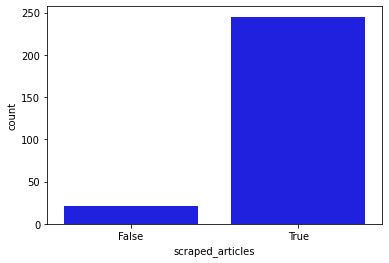

In [ ]:
data = run_query("""
MATCH (a:Article)
RETURN exists((a)-[:HAS_SECTION]->()) as scraped_articles, count(*) as count
""")
ax = sns.barplot(x="scraped_articles", y="count", data=data, color="blue")

In my case, I have successfully collected the information for 245 articles. Unless you have a time machine, you won't be able to recreate this analysis identically. I have scraped the website on the 30th of January 2021, and you will probably do it later. I have prepared most of the analysis queries generically, so they will work regardless of the date you choose to scrape the news.

Let's also examine the most frequent tags of the articles.

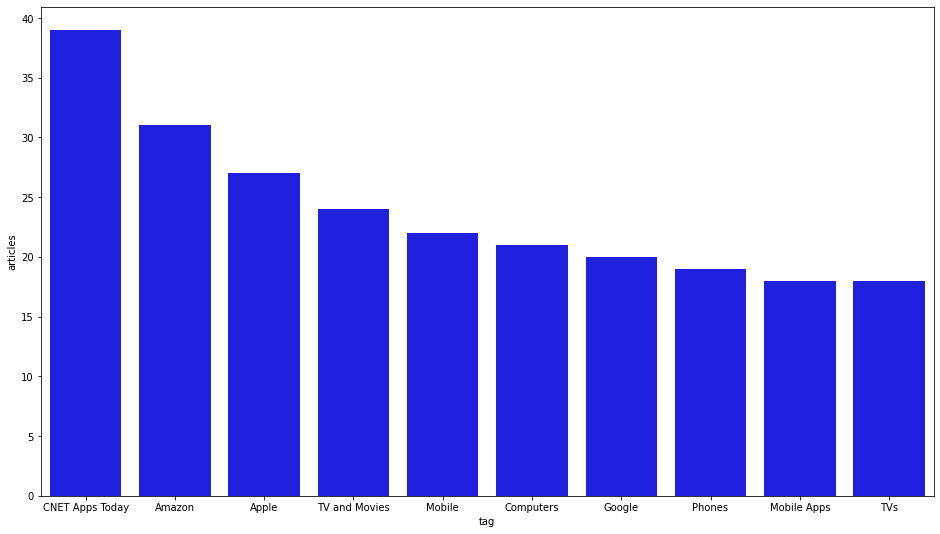

In [ ]:
data = run_query("""
MATCH (n:Tag)
RETURN n.name as tag, size((n)<-[:HAS_TAG]-()) as articles
ORDER BY articles DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="tag", y="articles", data=data, color="blue")

All charts in this blog post are made using the Seaborn library. CNET Apps Today is the most frequent tag. I think that's just a generic tag for daily news. We can observe that they have custom tags for various big companies such as Amazon, Apple, and Google.
### Named Entity Linking - Wikification
In my previous blog post, we have already covered the Named Entity Recognition techniques to create a knowledge graph. Here, we will take it up a notch and delve into Named Entity Linking. First of all, what exactly is Named Entity Linking?
Image by Aparravi on Wikipedia. Licensed under CC BY-SA 4.0Named entity linking is an upgrade to the entity recognition technique. It starts by recognizing all the entities in the text. Once it finishes the named entity recognition process, it tries to link those entities to a target knowledge base. Usually, the target knowledge bases are Wikipedia or DBpedia, but there are other knowledge bases out there as well. In the above example, we can observe that the named entity recognition process recognized Paris as an entity. The next step is to link it to a target entity in a knowledge base. Here, it uses Wikipedia as the target knowledge base. This is also known as the wikification process. The entity linking process is a bit tricky as we can see that many entities exist in Wikipedia that have Paris in their title. So, as a part of the entity linking process, the NLP model also does the entity disambiguation.
There are a dozen Entity linking models out there. Some of them are:
* http://wikifier.org/
* https://www.mpi-inf.mpg.de/departments/databases-and-information-systems/research/ambiverse-nlu/aida
* https://github.com/informagi/REL
* https://github.com/facebookresearch/BLINK

I am from Slovenia, so my biased decision is to use the Slovenian solution Wikifier [1]. They don't actually offer their NLP model, but they have a free to use API endpoint. All you have to do is to register. They don't even want your password or email, which is nice of them. The Wikifier supports more than 100 languages. It also features some parameters you can use to fine-tune the results. I have noticed that the most dominant parameter is the *pageRankSqThreshold* parameter, which you can use to optimize either recall or accuracy of the model.

The APOC library has the <code>apoc.load.json</code> procedure, which you can use to retrieve results from any API endpoints. If you are dealing with a larger amount of data, you will want to use the <code>apoc.periodic.iterate</code> procedure for batching purposes. If we put it all together, the following cypher query will fetch the annotation results for each section from the API endpoint and store the results to Neo4j.

In [ ]:
user_key = "insert-user-key"
run_query("""
CALL apoc.periodic.iterate('
 MATCH (s:Section) RETURN s
 ','
 WITH s, "http://www.wikifier.org/annotate-article?" +
        "text=" + s.text + "&" +
        "lang=en&" +
        "pageRankSqThreshold=0.80&" +
        "applyPageRankSqThreshold=true&" +
        "nTopDfValuesToIgnore=200&" +
        "nWordsToIgnoreFromList=200&" +
        "minLinkFrequency=100&" + 
        "maxMentionEntropy=10&" +
        "wikiDataClasses=false&" +
        "wikiDataClassIds=false&" +
        "userKey=" + $userKey as url
CALL apoc.load.json(url) YIELD value
UNWIND value.annotations as annotation
MERGE (e:Entity{wikiDataItemId:annotation.wikiDataItemId})
ON CREATE SET e.title = annotation.title, e.url = annotation.url
MERGE (s)-[:HAS_ENTITY]->(e)',
{batchSize:100, params: {userKey:$user_key}})
""", {"user_key":user_key})

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams
0,38,3722,3997,3722,0,0,0,{},"{'total': 38, 'committed': 38, 'failed': 0, 'e...","{'total': 3722, 'committed': 3722, 'failed': 0...",False,{}


The named entity linking process will take a couple of minutes. We can now check the most frequently mentioned entities.

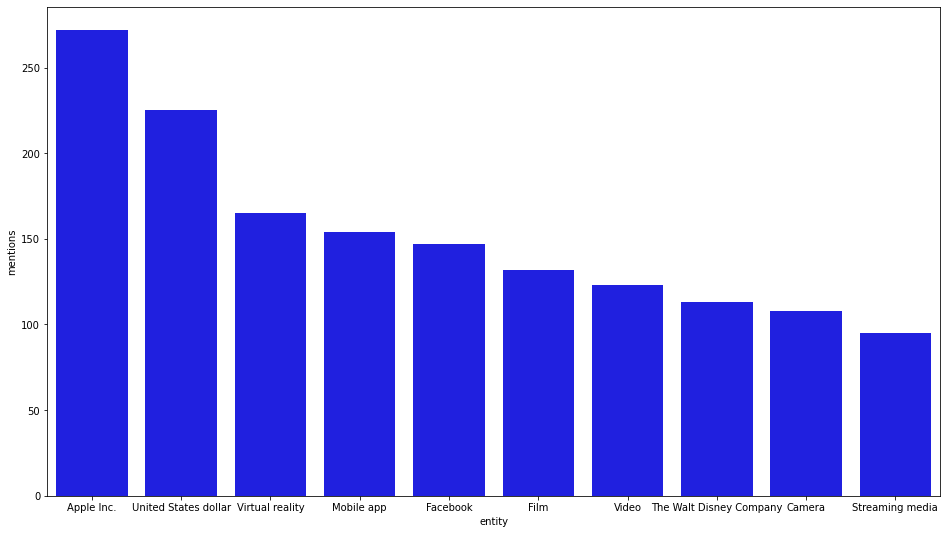

In [ ]:
data = run_query("""
MATCH (e:Entity)
RETURN e.title as entity, size((e)<--()) as mentions
ORDER BY mentions DESC LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="mentions", data=data, color="blue")

Apple Inc is the most frequently mentioned entity. I am guessing that all dollar signs or USD mentions get linked to the United States dollar. We call also examine the most frequently mentioned by article tags.

In [ ]:
run_query("""
MATCH (e:Entity)<-[:HAS_ENTITY]-()<-[:HAS_SECTION]-()-[:HAS_TAG]->(tag)
WITH tag.name as tag, e.title as title, count(*) as mentions
ORDER BY mentions DESC
RETURN tag, collect(title)[..3] as top_3_mentions
LIMIT 5;
""")

,tag,top_3_mentions
0,Virtual Reality,"[Virtual reality, Apple Inc., Facebook]"
1,Apple,"[Apple Inc., Virtual reality, IPhone]"
2,Wearable Tech,"[Apple Inc., Virtual reality, Apple Watch]"
3,TV and Movies,"[The Walt Disney Company, Film, HBO]"
4,Augmented reality (AR),"[Virtual reality, Apple Inc., Film]"


### WikiData enrichment
A bonus to using the wikification process is that we have the WikiData item id of our entities. This makes it very easy for us to scrape the WikiData API for additional information. Let's say we want to define all business and person entities. We will fetch the entity classes from WikiData API and use that information to group the entities. Again we will use the <code>apoc.load.json</code> procedure to retrieve the response from an API endpoint.

In [ ]:
run_query("""
// Iterate over entities
MATCH (e:Entity)
// Prepare a SparQL query
WITH 'SELECT * WHERE{ ?item rdfs:label ?name .filter (?item = wd:' + e.wikiDataItemId + ') filter (lang(?name) = "en" ) . ' +
      'OPTIONAL{ ?item wdt:P31 [rdfs:label ?class] .filter (lang(?class)="en") }}' AS sparql, e
// make a request to Wikidata
CALL apoc.load.jsonParams(
    "https://query.wikidata.org/sparql?query=" + 
    sparql,
     { Accept: "application/sparql-results+json"}, null)
YIELD value
UNWIND value['results']['bindings'] as row
FOREACH(ignoreme in case when row['class'] is not null then [1] else [] end | 
        MERGE (c:Class{name:row['class']['value']})
        MERGE (e)-[:INSTANCE_OF]->(c));    
""")

""


We will continue by inspecting the most frequent classes of the entities.

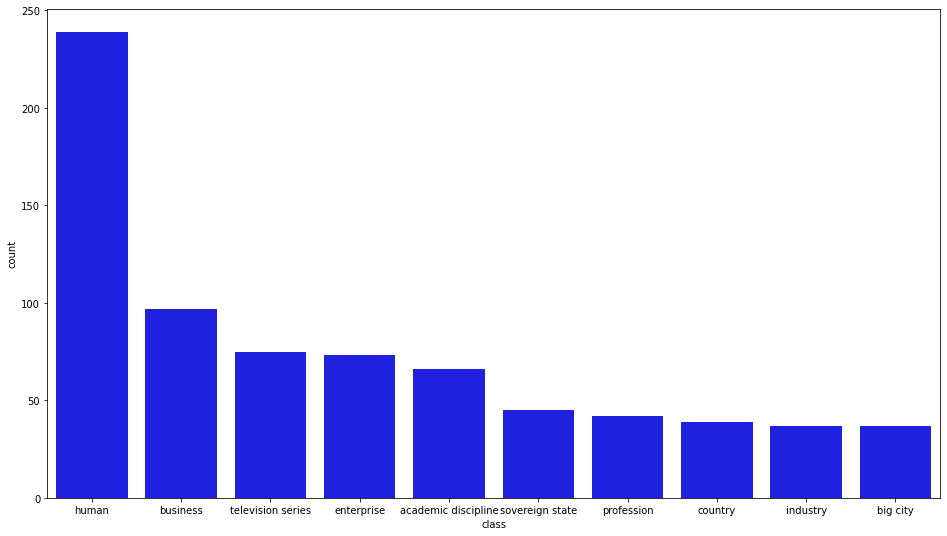

In [ ]:
data = run_query("""
MATCH (c:Class)
RETURN c.name as class, size((c)<--()) as count
ORDER BY count DESC LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="class", y="count", data=data, color="blue")

The wikification process found almost 250 human entities and 100 business entities. We will assign a secondary label to Person and Business entities to simplify our further cypher queries.

In [ ]:
run_query("""
MATCH (e:Entity)-[:INSTANCE_OF]->(c:Class)
WHERE c.name in ["human"]
SET e:Person;
""")
run_query("""
MATCH (e:Entity)-[:INSTANCE_OF]->(c:Class)
WHERE c.name in ["business", "enterprise"]
SET e:Business;
""")

""


With the added secondary label, we can now easily examine the most frequently mentioned business entities.

[Text(0, 0, 'Apple Inc.'),
 Text(1, 0, 'The Walt Disney Company'),
 Text(2, 0, 'Amazon (company)'),
 Text(3, 0, 'Google'),
 Text(4, 0, 'GameStop'),
 Text(5, 0, 'Netflix'),
 Text(6, 0, 'Marvel Comics'),
 Text(7, 0, 'Sony'),
 Text(8, 0, 'Best Buy'),
 Text(9, 0, 'Microsoft')]

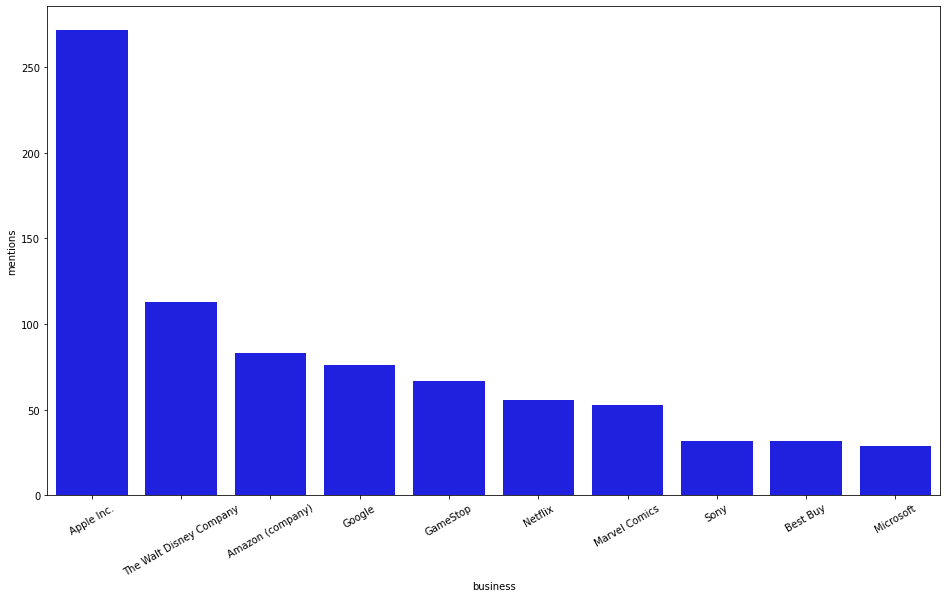

In [ ]:
data = run_query("""
MATCH (b:Business)
RETURN b.title as business, size((b)<-[:HAS_ENTITY]-()) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="business", y="mentions", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

We already knew that Apple and Amazon were discussed a lot. Some of you already know that this was an exciting week on the stock market, as we can see lots of mentions of GameStop.

Just because we can, let's also fetch the industries of the business entities from the WikiData API.

In [ ]:
run_query("""
MATCH (e:Business)
// Prepare a SparQL query
WITH 'SELECT * WHERE{ ?item rdfs:label ?name . filter (?item = wd:' + e.wikiDataItemId + ') filter (lang(?name) = "en" ) . + 
      'OPTIONAL{ ?item wdt:P452 [rdfs:label ?industry] .filter (lang(?industry)="en")}}' AS sparql, e
// make a request to Wikidata
CALL apoc.load.jsonParams(
    "https://query.wikidata.org/sparql?query=" + 
    sparql,
     { Accept: "application/sparql-results+json"}, null)
YIELD value
UNWIND value['results']['bindings'] as row
FOREACH(ignoreme in case when row['industry'] is not null then [1] else [] end | 
        MERGE (i:Industry{name:row['industry']['value']})
        MERGE (e)-[:PART_OF_INDUSTRY]->(i));
""")

""


### Exploratory graph analysis
Our data pipeline ingestion is complete. Now we can have some fun and explore our knowledge graph. First, we will examine the most co-occurrent entities of the most frequently mentioned entity, which is Apple Inc in my case.

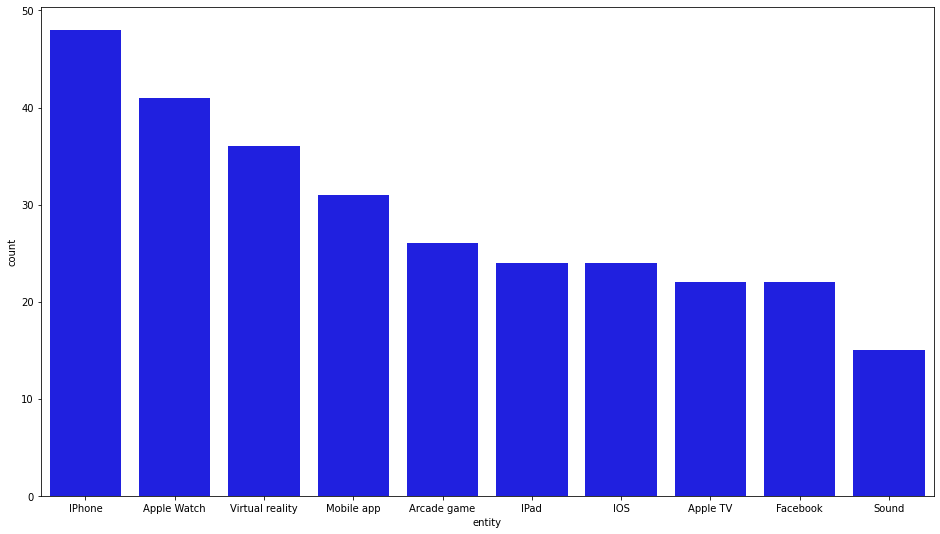

In [ ]:
data = run_query("""
MATCH (b:Business)
WITH b, size((b)<-[:HAS_ENTITY]-()) as mentions
ORDER BY mentions DESC 
LIMIT 1
MATCH (other_entities)<-[:HAS_ENTITY]-()-[:HAS_ENTITY]->(b)
RETURN other_entities.title as entity, count(*) as count
ORDER BY count DESC
LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="count", data=data, color="blue")

Nothing spectacular here. Apple Inc appears in sections where also iPhone, Apple Watch, and VR are being mentioned. We can look at some more exciting news. I was searching for any relevant tags of articles that might be interesting. CNET has many specific tags, but the Stock Market tag stood out as more broad and very relevant in these times. Let's check the most frequently mentioned industries in the Stock Market category of articles.

[Text(0, 0, 'retail'),
 Text(1, 0, 'video game industry'),
 Text(2, 0, 'e-commerce'),
 Text(3, 0, 'conglomerate'),
 Text(4, 0, 'consumer electronics'),
 Text(5, 0, 'technology industry'),
 Text(6, 0, 'software development'),
 Text(7, 0, 'software industry'),
 Text(8, 0, 'telecommunications industry'),
 Text(9, 0, 'automotive industry')]

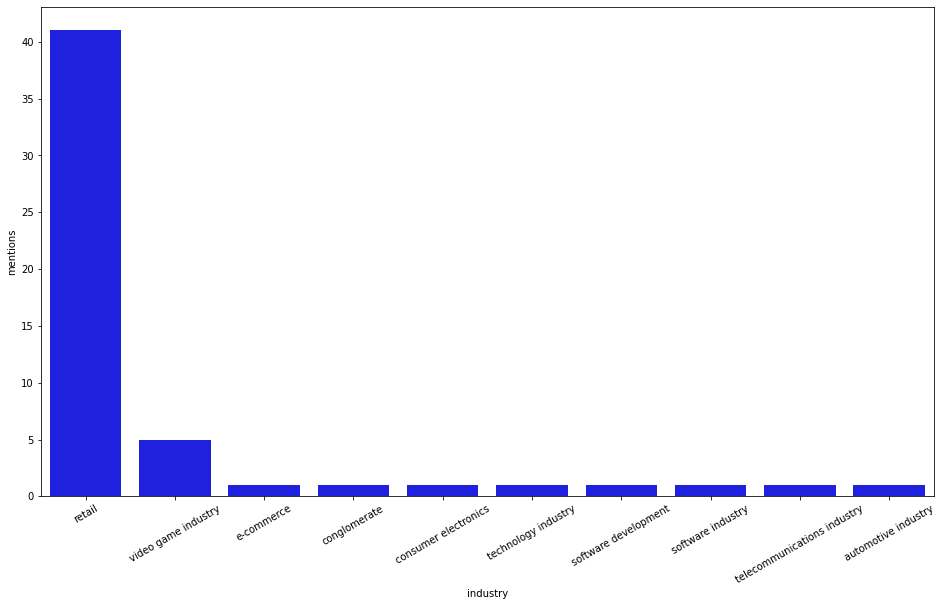

In [ ]:
data = run_query("""
MATCH (t:Tag)<-[:HAS_TAG]-()-[:HAS_SECTION]->()-[:HAS_ENTITY]->(entity:Business)-[:PART_OF_INDUSTRY]->(industry)
WHERE t.name = "Stock Market"
RETURN industry.name as industry, count(*) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="industry", y="mentions", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

Retail is by far the most mentioned, next is the video game industry, and then some other industries that are mentioned only once. Next, we will check the most mentioned businesses or persons in the Stock Market category.

[Text(0, 0, 'GameStop'),
 Text(1, 0, 'Jim Cramer'),
 Text(2, 0, 'Elon Musk'),
 Text(3, 0, 'Alexandria Ocasio-Cortez'),
 Text(4, 0, 'Ubisoft'),
 Text(5, 0, 'Tesla, Inc.'),
 Text(6, 0, 'Rashida Tlaib'),
 Text(7, 0, 'Donald Trump'),
 Text(8, 0, 'Etsy'),
 Text(9, 0, 'Jon Stewart')]

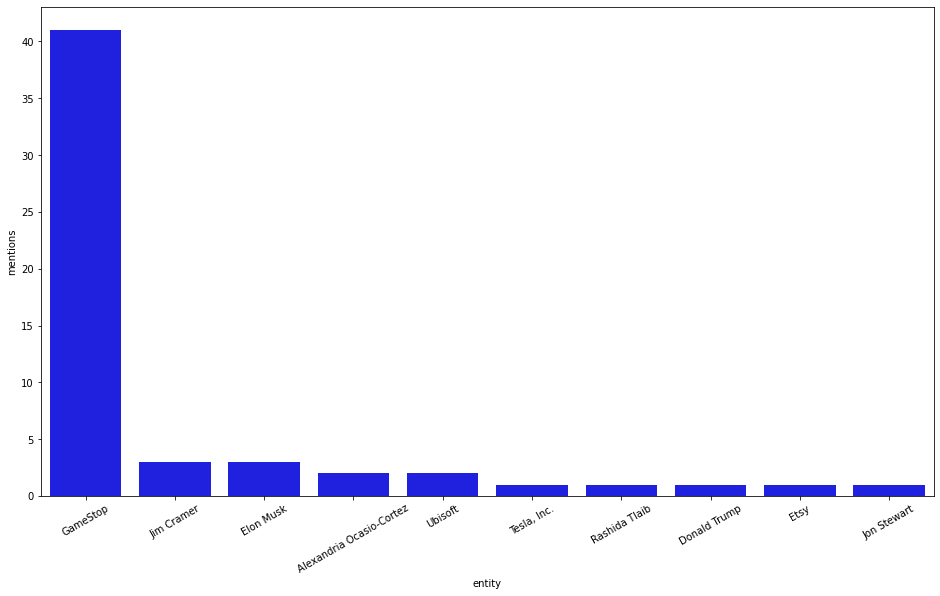

In [ ]:
data = run_query("""
MATCH (t:Tag)<-[:HAS_TAG]-()-[:HAS_SECTION]->()-[:HAS_ENTITY]->(entity)
WHERE t.name = "Stock Market" AND (entity:Person OR entity:Business)
RETURN entity.title as entity, count(*) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="mentions", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

Ok, so GameStop is huge this weekend with more than 40 mentions. Very far behind are Jim Cramer, Elon Musk, and Alexandria Ocasio-Cortez. We will try to understand why GameStop is so huge by looking at the co-occurring entities.

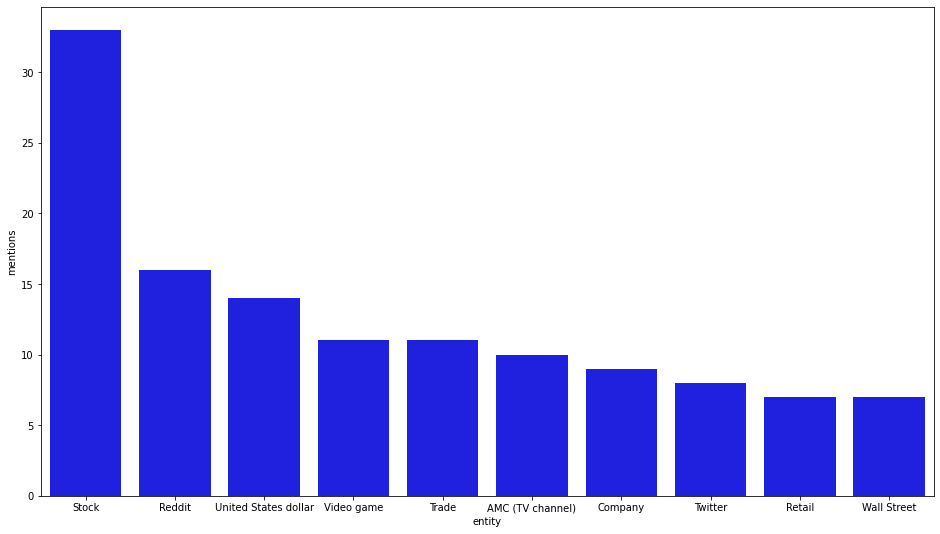

In [ ]:
data = run_query("""
MATCH (b:Business{title:"GameStop"})<-[:HAS_ENTITY]-()-[:HAS_ENTITY]->(other_entity)
RETURN other_entity.title as entity, count(*) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="mentions", data=data, color="blue")

The most frequently mentioned entities in the same section as GameStop are Stock, Reddit, and US dollar. If you look at the news you might see that the results make sense. I would venture a guess that the AMC (TV channel) was wrongly identified and should probably be the AMC Theaters company. There will always be some mistakes in the NLP process. We can filter the results a bit and look for the most co-occurring person or business entities of GameStop.

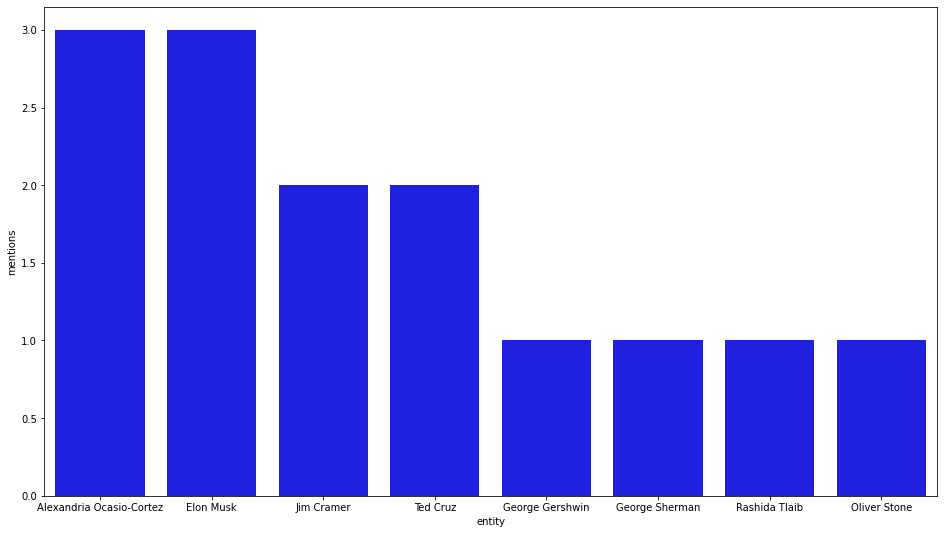

In [ ]:
data = run_query("""
MATCH (b:Business{title:"GameStop"})<-[:HAS_ENTITY]-()-[:HAS_ENTITY]->(other_entity:Person)
RETURN other_entity.title as entity, count(*) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="mentions", data=data, color="blue")

Alexandria Ocasio-Cortez and Elon Musk each appear in three sections with GameStop. Let's examine the text where AOC co-occurs with GameStop.

In [ ]:
run_query("""
MATCH (b:Business{title:"GameStop"})<-[:HAS_ENTITY]-(section)-[:HAS_ENTITY]->(p:Person{title:"Alexandria Ocasio-Cortez"})
RETURN section.text as text
""")

,text
0,Rep. Alexandria Ocasio-Cortez took to Twitch t...
1,"Rep. Alexandria Ocasio-Cortez, a Democrat from..."
2,"Amid the recent stock market chaos, Robinhood ..."


### Graph data science
So far, we have only done a couple of aggregations using the Cypher query language. As we are utilizing a knowledge graph to store our information, let's execute some graph algorithms on it. Neo4j Graph Data Science library is a plugin for Neo4j that has at the moment more than 50 graph algorithms available. The algorithm range from community detection and centrality to node embedding and graph neural network categories.
We have already inspected some co-occurring entities so far. Now, we will infer a co-occurrence network of persons within our knowledge graph. This process basically translates indirect relationships, where two entities are mentioned in the same section, to a direct relationship between those two entities. The cypher query for inferring the person co-occurrence network is:

In [ ]:
run_query("""
MATCH (s:Person)<-[:HAS_ENTITY]-()-[:HAS_ENTITY]->(t:Person)
WHERE id(s) < id(t)
WITH s,t, count(*) as weight
MERGE (s)-[c:CO_OCCURENCE]-(t)
SET c.weight = weight
""")

""


The first graph algorithm we will use is the Weakly Connected Components algorithm. It is used to identify disconnected components or islands within the network.

In [ ]:
run_query("""
CALL gds.graph.project('co-occurrence', 'Person', 'CO_OCCURRENCE')
""")

In [ ]:
run_query("""
CALL gds.wcc.write(co-occurrence,{
    writeProperty:'wcc'})
YIELD componentCount, componentDistribution
""")

,writeMillis,nodePropertiesWritten,componentCount,componentDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,6,239,134,"{'p99': 7, 'min': 1, 'max': 30, 'mean': 1.7835...",3,8,1,"{'writeConcurrency': 4, 'seedProperty': None, ..."


The algorithm found 134 disconnected components within our graph. The p50 value is the 50th percentile of the community size. Most of the components consist of a single node. This implies that they don't have any CO_OCCURENCE relationships. The largest island of nodes consists of 30 members. We will mark its members with a secondary label.

In [ ]:
run_query("""
MATCH (p:Person)
WITH p.wcc as wcc, collect(p) as members
ORDER BY size(members) DESC LIMIT 1
UNWIND members as member
SET member:LargestWCC
""")

""


We will further analyze the largest component by examining its community structure and trying to find the most central nodes. When you have a plan to run multiple algorithms on the same projected graph, it is better to use a named graph. The relationship in the co-occurrence network will be treated as undirected.

In [ ]:
run_query("""
CALL gds.graph.project('person-cooccurence', 'LargestWCC', 
  {CO_OCCURENCE:{orientation:'UNDIRECTED'}}, {relationshipProperties:['weight']})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,"{'LargestWCC': {'properties': {}, 'label': 'La...","{'CO_OCCURENCE': {'orientation': 'UNDIRECTED',...",person-cooccurence,30,114,14


First, we will run the PageRank algorithm, which will help us identify the most central nodes.

In [ ]:
run_query("""
CALL gds.pageRank.write('person-cooccurence', {relationshipWeightProperty:'weight', writeProperty:'pagerank'})
""")

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,2,30,20,False,"{'p1': 0.3021354675292969, 'max': 4.2606487274...",3,1,177,"{'maxIterations': 20, 'writeConcurrency': 4, '..."


Next, we will run the Louvain algorithm, which is a community detection algorithm.

In [ ]:
run_query("""
CALL gds.louvain.write('person-cooccurence', {relationshipWeightProperty:'weight', writeProperty:'louvain'})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,2,30,0.552532,"[0.5419501133786848, 0.5525321239606953]",2,5,"{'p99': 10, 'min': 3, 'max': 10, 'mean': 6.0, ...",2,0,77,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


### Conclusion
I really love how NLP and knowledge graphs are a perfect match. Hopefully, I have given you some ideas and pointers on how you can go about implementing your data pipeline and storing results in a form of a knowledge graph. Let me know what do you think!